# Chapter 2: data and sampling distributions

It's not because you have lots of data that it's high quality, and unbiased.

`sample` is subset of data from a `population`.
Population can exist in real life, or be theoretical.

Bias: systematic error due to the sampling or measurement methods. When a sample is biased, it misrepresents the population. Ex: self-selection bias. 

# Stratified sampling

Looking at the Titanic dataset, this section illustrates: 
1. `sample bias`: if we sampled passengers at the Cherbourg docks vs on the boat.
2. `stratified sampling`: if we know the proportion of passengers from each city,
we can sample proportionally and measure a sample mean similar 
to that of sampling from the whole pop.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


def load_data():
    df = sns.load_dataset('titanic')
    # sibsp: number of siblings/spouses on Titanic.
    # parch: number of parent/children on Titanic.
    # fare: in 1912 GB pounds. Multiply by 5 for 2018 USD.
    # deck: A-F, often null
    columns = ['class','sex','sibsp','parch','alone','fare','deck','embark_town','alive']
    df = df[columns]
    df.rename({'class':'pclass', 'alive':'outcome'}, axis='columns', inplace=True)
    df['outcome'].replace({'yes':'alive','no':'dead'}, inplace=True)
    return df
    
df = load_data()
print(df.shape)
df.sample(5)

(891, 9)


,pclass,sex,sibsp,parch,alone,fare,deck,embark_town,outcome
846,Third,male,8,2,False,69.550,NaN,Southampton,dead
214,Third,male,1,0,False,7.750,NaN,Queenstown,dead
292,Second,male,0,0,True,12.875,D,Cherbourg,dead
442,Third,male,1,0,False,7.775,NaN,Southampton,dead
283,Third,male,0,0,True,8.050,NaN,Southampton,alive


In [2]:
# example of sample bias: sample passengers at cherbourg vs on the boat
def get_pct(val):
    """ return a func computing the % of elements in a series equal to val """
    return lambda s: sum(s==val) / len(s)

(
    df
    .groupby('embark_town')
    .agg(
        {
            'sibsp': 'count',
            'outcome': get_pct('alive'),
            'pclass': get_pct('First'),
            'fare': 'median',
            'alone': get_pct(True),
            'sex': get_pct('male')
        }
    )
    .rename(
        {
            'sibsp': 'n',
            'outcome':'pct_survived',
            'pclass': 'pct_first_class',
            'fare': 'fare_median',
            'alone': 'pct_alone',
            'sex': 'pct_male',
        },
        axis='columns'
    )
)

,n,pct_survived,pct_first_class,fare_median,pct_alone,pct_male
embark_town,,,,,,
Cherbourg,168,0.553571,0.505952,29.70,0.505952,0.565476
Queenstown,77,0.389610,0.025974,7.75,0.740260,0.532468
Southampton,644,0.336957,0.197205,13.00,0.610248,0.684783


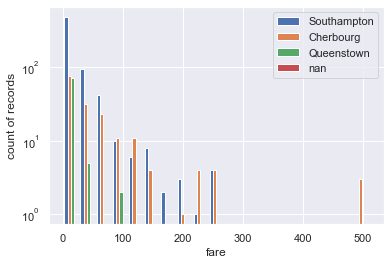

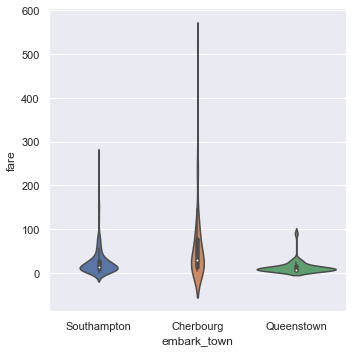

In [3]:
# Cherbourg passengers have a higher fare
def plot_hist_by_category(
    df, numerical_colname, categ_colname,
    ylog=False, stacked=False,
    n_bins=20, legend_loc='upper right'
):
    """ plot a histogram of numerical_colname
    split by categ_colname
    Recommended usage: if ylog, don't stack.
    For overlapping bars, see https://stackoverflow.com/a/6873956
    """
    bins = np.linspace(
        df[numerical_colname].min(), 
        df[numerical_colname].max(), 
        n_bins
    )
    cat_values = df[categ_colname].unique()
    x_arrays = []
    
    for cat in cat_values:
        x = list(df[df[categ_colname]==cat][numerical_colname])
        x_arrays.append(x)
        
    ax = plt.hist(
        x_arrays,
        bins=bins,
        density=False,
        label=cat_values,
        stacked=stacked,
    )
    
    if ylog:
        plt.yscale('log')
        
    plt.legend(loc=legend_loc)
    plt.xlabel(numerical_colname)
    plt.ylabel('count of records')
    plt.show()

    
plot_hist_by_category(df, 'fare', 'embark_town', ylog=True)

# https://seaborn.pydata.org/tutorial/categorical.html
sns.catplot(x="embark_town", y="fare", kind="violin", data=df); # different distribution of fare by city


                  sample_mean
sampling                     
Cherbourg only      59.622694
stratified          32.220409
whole population    31.645276
true total pop mean: 32.2042


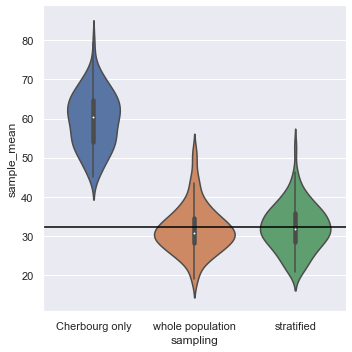

In [4]:
# Show that computing avg fare from the Cherbourg docks does not reflect avg fare on overall Titanic.
# Find out how much closer stratified sampling by city is to the Titanic mean.

# simulate sampling 70 passengers:
# 1) from the Cherbourg docks,
# 2) on the boat, ("true" population)
# 3) stratified: on the boat, knowing the distribution by city
# compare all 3 to the true pop mean, looking at all ~900 passengers


def simulate_stratified_means(
    df, numerical_colname, categ_colname, sample_size=70, n_simulations=100
):
    """
    simulate stratified sample from df, 
    startified by categ_colname,
    where outcome variable is numerical_colname
    """
    
    stratified_means = []
    
    # compute expected strata sizes first
    # {'Cherbourg': 13, 'Queenstown': 6, 'Southampton': 51}
    agg = df.groupby(categ_colname).size().reset_index().to_numpy() # n_categ x 2
    all_categs = list(agg[:,0])
    qty = agg[:,1].astype(float)
    qty = (qty / qty.sum() * sample_size).round().astype(int)
    categs_strata_n = dict(zip(all_categs, qty))  
    
    # run strata simulations
    for i in range(n_simulations):
        strata_values = [
            df[df[categ_colname]==strata_name].sample(strata_n, random_state=i)[numerical_colname]
            for strata_name, strata_n in categs_strata_n.items()
        ]
        strata_values = [val for sublist in strata_values for val in sublist] # flatten
        stratified_mean = np.array(strata_values).mean()
        stratified_means.append(stratified_mean)
    
    return stratified_means


def simulate_sample_means(series, sample_size=70, n_simulations=100):
    """ given a series, run n_simulations
    where we draw sample_size individuals without replacement
    and compute the mean.
    return n_simulations means.
    """
    means = []
    for i in range(n_simulations):
        mean = series.sample(sample_size, random_state=i).mean()
        means.append(mean)

    return means


def simulate_means(df, numerical_colname, categ_colname, categ):
    """
    Simulate 3 sampling methods: sample numerical_colname 
    1) from whole pop, 2) from categ_colname==categ only, 
    and 3) stratified according to categ_colname.
    
    Return a df mapping sampling to sample_mean, 
    with one row per sim iteration per sampling method.
    """
    
    sample_size = 70
    n_simulations = 100
    
    series = df[df[categ_colname]==categ][numerical_colname]
    categ_means = simulate_sample_means(
        series, sample_size, n_simulations
    )
        
    pop_means = simulate_sample_means(
        df[numerical_colname], sample_size, n_simulations
    )
    
    stratified_means = simulate_stratified_means(
        df, numerical_colname, categ_colname, sample_size, n_simulations
    )
    
    # wrangle together the means from pop, categ, and stratified
    means_df = (
        pd.DataFrame(
            {
                categ + ' only': categ_means,
                'whole population': pop_means,
                'stratified': stratified_means,
            }
        )
        .stack()
    )
    means_df = means_df.reset_index().drop('level_0', axis='columns')
    means_df.columns = ['sampling', 'sample_mean']
    
    return means_df


def draw_means_violin_plot(means_df, pop_mean):
    """ draw horizontal violin plot of each type of mean,
    and draw a vertical line for the true population mean.
    
    means_df: 2 columns: sampling (categorical), sample_mean (numerical)
    pop_mean: scalar
    """
    print(means_df.groupby('sampling').mean())
    print(f'true total pop mean: {pop_mean:.4f}')
    
    facetgrid = sns.catplot( 
        x='sampling', y="sample_mean", kind="violin", data=means_df
    )    
    facetgrid.ax.axhline(y=pop_mean, color='black')
    plt.show()
    
    
means_df = simulate_means(df, 'fare', 'embark_town', categ='Cherbourg')
pop_mean = df['fare'].mean()
draw_means_violin_plot(means_df, pop_mean)

# Regression to the mean

When measuring successively, extreme observations tend to be followed by more typical ones.
Examples:
- Rookie of the year, sophomore slump: if a sport involves some skill but a lot of luck, and the player has highest win rate in year 1, they probably will have a lower (average) win rate the next year. 
- Children of very tall parents aren't as tall as their parents. 
Let's look at [Galton data](http://www.medicine.mcgill.ca/epidemiology/hanley/galton/).

In [5]:
# let's look at height of parents vs children
# numbers are height offsets vs 60 inches (152.4cm), so 3 means 63
# data is sorted by height offset of father, descendingly
# family id, father height, mother height, sons1 to 10, d1 to 9

def load_galton_data():
    filename = 'family_height_parents_children_galton.csv'
    df = pd.read_csv(filename)
    return df

df = load_galton_data()
print(df.shape)
df.head()

(205, 23)


,fam,dad,mom,s1,s2,s3,s4,s5,s6,s7,...,d1,d2,d3,d4,d5,d6,d7,d8,d9,n_children
0,1,18.5,7.0,13.2,*,*,*,*,*,*,...,9.2,9,9,*,*,*,*,*,*,4
1,2,15.5,6.5,13.5,12.5,*,*,*,*,*,...,5.5,5.5,*,*,*,*,*,*,*,4
2,3,15.0,4.0,11,*,*,*,*,*,*,...,8,*,*,*,*,*,*,*,*,2
3,4,15.0,4.0,10.5,8.5,*,*,*,*,*,...,7,4.5,3,*,*,*,*,*,*,5
4,5,15.0,-1.5,12,9,8,*,*,*,*,...,6.5,2.5,2.5,*,*,*,*,*,*,6


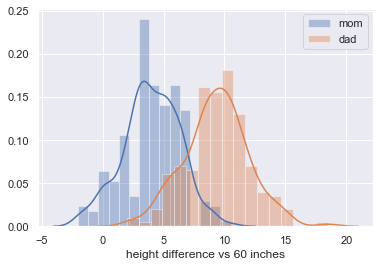

In [6]:
def print_all_values(df):
    # print all values in df, to debug
    pd.unique(df.drop('fam',axis=1).values.ravel('K')) 

def hist_columns(df, cols):
    x = pd.to_numeric(df[cols].values.ravel('K'))
    sns.distplot(x, label='+'.join(cols)).set_xlabel('height difference vs 60 inches')
    plt.legend()

hist_columns(df, ['mom']) 
hist_columns(df, ['dad']) 
# hist_columns(df, ['dad','mom']) # both put together, bimodal


In [7]:
def cleanup(df):
    """
    replace '*' with NaN,
    and map adjectives like 'short' to values based on distribution above
    output a df with one row per child
    """
    
    # replacements
    adj_mapping = {
        'short': 0, 
        'shortish': 3,
        'middle': 6,
        'medium': 6,
        'med.': 6, 
        'tallish': 9, 
        'tall': 12, 
        'v.tall': 15,
        'deformed': np.nan, 
        'idiotic': np.nan,
    }
    
    ddf = (
        df
        .replace('*', np.nan)
        .replace(adj_mapping)
    )
    
    # unstack
    son_cols = [f's{i}' for i in range(1,11)]
    dgt_cols = [f'd{i}' for i in range(1,10)]
    ddf = pd.melt(
        ddf, 
        id_vars=['fam','dad','mom','n_children'], 
        value_vars=son_cols + dgt_cols,
        var_name='child', 
        value_name='hdiff'
    ).dropna()
    
    # replace s1-10 and d1-9 with male/female. Ignore son/daughter ranks.
    ddf['child_gender'] = (
        ddf['child'].str.extract('([sd])')
        .replace({'s':'male', 'd': 'female'})
    )
    ddf.drop('child', axis=1, inplace=True)
    
    # add absolute height columns (in inches): dad_h, mom_h, child_h.
    ddf['dad_h'] = 60 + ddf['dad'].astype(float) 
    ddf['mom_h'] = 60 + ddf['mom'].astype(float)
    ddf['child_h'] = 60 + ddf['hdiff'].astype(float)
    ddf['child_minus_dad'] = ddf['child_h'] - ddf['dad_h']
    ddf['child_minus_mom'] = ddf['child_h'] - ddf['mom_h']
    
    # enforce types
    ddf['hdiff'] = ddf['hdiff'].astype('float')
    
    return ddf


ddf = cleanup(df)
ddf.sort_values(by=['fam','child_gender']).to_csv(
    'family_height_parents_children_galton_clean.csv', 
    float_format='%.1f', 
    index=False
)
print(ddf.shape)
ddf.sort_values(by='fam').head(10)


(960, 11)


,fam,dad,mom,n_children,hdiff,child_gender,dad_h,mom_h,child_h,child_minus_dad,child_minus_mom
0,1,18.5,7.0,4,13.2,male,78.5,67.0,73.2,-5.3,6.2
2255,1,18.5,7.0,4,9.0,female,78.5,67.0,69.0,-9.5,2.0
2050,1,18.5,7.0,4,9.2,female,78.5,67.0,69.2,-9.3,2.2
2460,1,18.5,7.0,4,9.0,female,78.5,67.0,69.0,-9.5,2.0
2059,10,14.0,5.5,1,5.5,female,74.0,65.5,65.5,-8.5,0.0
99,100,9.0,6.0,3,11.2,male,69.0,66.0,71.2,2.2,5.2
509,100,9.0,6.0,3,10.0,male,69.0,66.0,70.0,1.0,4.0
304,100,9.0,6.0,3,11.0,male,69.0,66.0,71.0,2.0,5.0
305,101,9.0,6.7,4,14.0,male,69.0,66.7,74.0,5.0,7.3
715,101,9.0,6.7,4,8.5,male,69.0,66.7,68.5,-0.5,1.8


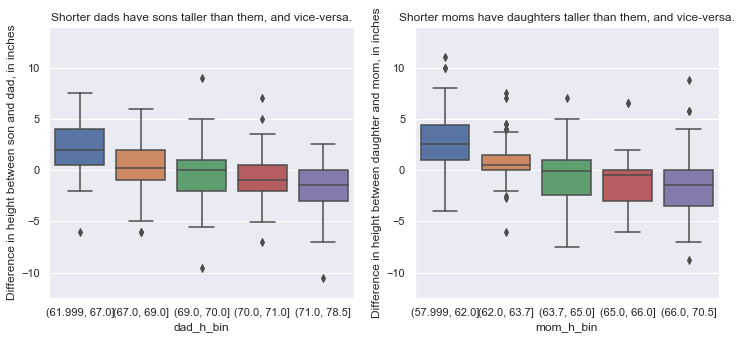

In [8]:
def boxplot_mom_dad_vs_children(df, n_quantiles=5):
    """
    Draw 2 boxplots next to each other.
    Left has height difference in inches between son and dad.
    Right has height difference in inches between daughter and mom.
    Bin parent height into n_quantiles.
    """
    
    df['dad_h_bin'] = pd.qcut(df['dad_h'], n_quantiles)
    df['mom_h_bin'] = pd.qcut(df['mom_h'], n_quantiles)

    fig, axes = plt.subplots(1,2, figsize=(12, 5))
    ylim = (
        min(
            df['child_minus_dad'].min(),
            df['child_minus_mom'].min()
        ),
        max(
            df['child_minus_dad'].max(),
            df['child_minus_mom'].max()
        )
    )
    
    # left plot
    ax = axes[0]
    (
        sns.boxplot(
            x='dad_h_bin',
            y='child_minus_dad',
            data=df.query('(child_gender == "male")'),
            ax=ax
        )
        
    )
    ax.set_title('Shorter dads have sons taller than them, and vice-versa.')
    ax.set_ylabel('Difference in height between son and dad, in inches')
    ax.set(ylim=ylim)
    
    # right plot
    ax = axes[1]
    (
        sns.boxplot(
            x='mom_h_bin',
            y='child_minus_mom',
            data=df.query('(child_gender == "female")'),
            ax=axes[1]
        )
    )
    ax.set_title('Shorter moms have daughters taller than them, and vice-versa.')
    ax.set_ylabel('Difference in height between daughter and mom, in inches')
    ax.set(ylim=ylim)

    
boxplot_mom_dad_vs_children(ddf)

# Sampling distribution of a statistic

- `Sample statistic`: metric calculated for a sample draw from a larger population, eg the mean or median.
- `Data distribution` is about the frequency of the values of individual data points in a dataset. 
- `Sampling distribution` is about the frequency of the values of a sample statistic.
- `Standard error`: standard deviation (ie variability) of a sample statistic over many samples. This is not the standard deviation of individual values.
- `Central Limit Theorem`: the sampling distribution converges towards a bell shape as the sample size increases.

In [9]:
# look at titanic data again

df = load_data()
print(df.shape)
df.sample(5)

(891, 9)


,pclass,sex,sibsp,parch,alone,fare,deck,embark_town,outcome
423,Third,female,1,1,False,14.4000,NaN,Southampton,dead
866,Second,female,1,0,False,13.8583,NaN,Cherbourg,alive
651,Second,female,0,1,False,23.0000,NaN,Southampton,alive
472,Second,female,1,2,False,27.7500,NaN,Southampton,alive
798,Third,male,0,0,True,7.2292,NaN,Cherbourg,dead


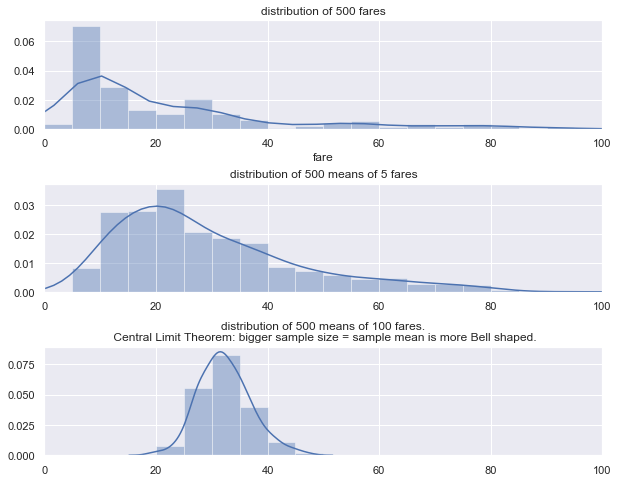

In [10]:
# sample 500 means of 5 fares
def compute_sample_statistic(
    series, n_samples, sample_size, statistic=np.mean, seed=123
):
    """ Sample series and compute its mean, N times.
    Return a series of means. """
    means = []
    for itr in range(n_samples):
        mean = statistic(
            series.sample(
                n=sample_size, random_state=seed+itr
            )
        )
        means.append(mean)
        
    return pd.Series(means)


def plot_sampled_fare_means(df):
    """ plot sampled fares, and 2 sampled means of fares
    """
    sample_size = 500
    fig, axes = plt.subplots(3, 1, figsize=(10, 8))
    plt.subplots_adjust(hspace=.5)
    bins = list(range(0, int(df['fare'].max()),5))

    # sample 500 fares
    ax = axes[0]
    sns.distplot(
        df['fare'].sample(n=sample_size, random_state=123),
        bins=bins,
        ax=ax
    )
    ax.set_xlim(0,100)
    ax.set_title(f"distribution of {sample_size} fares")

    n_fares = 5
    ax = axes[1]
    sns.distplot(
        compute_sample_statistic(df['fare'], sample_size, n_fares),
        bins=bins,
        ax=ax
    )
    ax.set_xlim(0,100)
    ax.set_title(f"distribution of {sample_size} means of {n_fares} fares")

    # sample 500 means of 100 fares
    n_fares = 100
    ax = axes[2]
    sns.distplot(
        compute_sample_statistic(df['fare'], sample_size, n_fares),
        bins=bins,
        ax=ax
    )
    ax.set_xlim(0,100)
    ax.set_title(
        f"distribution of {sample_size} means of {n_fares} fares."
        "\n Central Limit Theorem: bigger sample size = sample mean is more Bell shaped."
    )

    
plot_sampled_fare_means(df)